In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import poisson
from scipy.special import gammaln
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.linear_model import PoissonRegressor
import pyreadr
np.random.seed(42)
# matplotlibで日本語を使えるように
plt.rcParams["font.family"] = "IPAGothic"

In [2]:
data3a = pd.read_csv("../chapter3/data3a.csv")

<h1>5 一般化線形モデルの尤度比検定と検定の非対称性</h1>

この本では統計モデルによる推定・予測を重視する方向性なのでAICによるモデル選択と同様に、検定は推定された統計モデルを比較する方法のひとつにすぎません。  
この章ではどのような統計モデルでも利用可能な尤度比検定について学びます。  
尤度比検定はどのような統計モデルであって、逸脱度の差に注目してネストしているモデルたちを比較できます。  

<h1>5.1 統計学的な検定のわくぐみ</h1>

ネストしているパラメータの少ないモデルと多いモデルの二つを比較します。  
統計学的な検定ではそれぞれ帰無仮説、対立仮設と呼びます。帰無仮説とは「棄却されるための仮設」であり、「無に帰される」時にその役割を果たす特殊な統計モデルという位置づけです。  
統計モデルの検定では、「帰無仮説は正しい」という命題が否定できるかどうか、その点だけを調べます。  
まず、モデルのあてはまりのよさ等を検定統計量に指定します。  
次に帰無仮説が「真のモデル」であると仮定して、そのときに検定統計量の理論的なばらつきを調べて検定統計量がとりうる「ありがちな範囲」を定めます。この「ありがちな範囲」の大きさが95%である場合は、5%の有意水準を設定したと言います。  
最後に対立仮設のモデルで得られた検定統計量が、この「ありがちな範囲」からはみ出ているかどうかを確認し、もしはみ出ていれば帰無仮説は棄却され、対立仮説が支持されたと結論されます。この検定の枠組みをNeyman-Pearsonの検定の枠組みといいます。

<h1>5.2 尤度比検定の例題:逸脱度の差を調べる</h1>

今回の例題では、第三章で使った種子数データを使います。  
使用するモデルは$λ_i=exp(\beta_1+\beta_2x_i)$を平均とするポアソン回帰モデルです。  
ネストしている一定モデルと$x$モデルを比較して帰無仮説となる一定モデルが棄却できるかどうかを調べます。  
・一定モデル: 種子数の平均$λ_i$が定数であり、体サイズ$x_i$に依存しないモデル(傾き$\beta_2=0$, パラメータ数$k=1$)  
・$x$モデル:  種子数の平均$λ_i$が体サイズ$x_i$に依存するモデル(傾き$\beta_2\neq0$, パラメータ数$k=2$)  
この二つのモデルのポアソン回帰の結果は以下のようになります。  
| モデル | パラメータ数k | 尤度($logL^*$) | 逸脱度($-2logL^*$) | 残差逸脱度 | AIC |
|------|-------|------|-------|------|-------|
| 一定 | 1 | -237.6 | 475.3 | 89.5 | 477.3 |
| x | 2 | -235.4 | 470.8 | 85.0 | 474.8 |
| フル | 100 | -192.9 | 385.8 | 0.0 | 585.8 |  

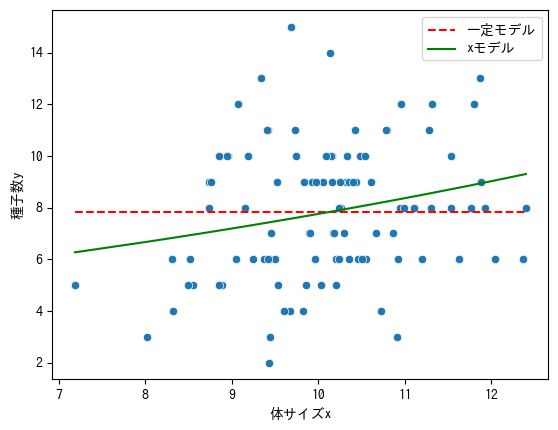

In [19]:
preds = {}
models = {}
# 説明変数に切片を追加
X = sm.add_constant(data3a[["x"]])
# 切片項のみのポアソン回帰
model = sm.GLM(data3a["y"], X["const"], family=sm.families.Poisson()).fit()
models["一定モデル"] = model
preds["一定モデル"] = model.predict(X["const"])
# 説明変数に体サイズxを含めたポアソン回帰
model = sm.GLM(data3a["y"], X, family=sm.families.Poisson()).fit()
models["xモデル"] = model
preds["xモデル"] = model.predict(X)

# グラフを描写
sns.scatterplot(data3a,x="x",y="y")
x_sorted_idx = np.argsort(X["x"])
plt.plot(X["x"].iloc[x_sorted_idx], preds["一定モデル"].iloc[x_sorted_idx],
          linestyle="--",color="red",label="一定モデル")
plt.plot(X["x"].iloc[x_sorted_idx], preds["xモデル"].iloc[x_sorted_idx],
         color="green",label="xモデル")
plt.xlabel("体サイズx")
plt.ylabel("種子数y")
plt.legend(loc="upper right")
plt.show()

逸脱度を比較すると、一定モデルが475.3でxモデルが470.8であり逸脱度の差は4.5ぐらいです。  
ネストしたモデルでは第4章で見たように同じデータに対して、パラメータ数の多いモデルの方が常に逸脱度は小さくなります。  
この検定では尤度比というものを扱います。尤度人はこの例題の場合だと以下のようになります。  
$\frac{L_1^*}{L_2^*}=\frac{一定モデルの最大尤度:exp(-237.6)}{xモデルの最大尤度:exp(-235.4)}$  
この尤度の対数を取り、-2をかけて逸脱度に変換します。  
$ΔD_{1,2}=-2(logL_1^*-logL_2^*)$  
この二つのモデルの逸脱度の差を検定統計量として使います。  
ここでの例題データでは一定モデルとxモデルの逸脱度の差は$ΔD_{1,2}=4.5$ぐらいとなっていました。  
尤度比検定では検定統計量であるこの逸脱度の差が「4.5ぐらいでは改善されていない」と仮説を立て、  
それを棄却できるかどうかを調べていきます。  

<h1>5.3 2種類の過誤と統計学的な検定の非対称性</h1>

Neyman-Pearsonの検定の枠組みでは、比較するモデルを帰無仮説と対立仮説に分類します。  
この例題の場合だと帰無仮説、対立仮説を以下のように設定します。  
・帰無仮説: 一定モデル(パラメータ数$k=1$, $\beta_2=0$)  
・対立仮説: xモデル(パラメータ数$k=2$, $\beta_2\neq0$)  
このように帰無仮説、対立仮説を設定すると「帰無仮説が正しくなければ対立仮説は正しい」あるいは「対立仮説が正しくなければ帰無仮説が正しい」が成立するような気がします。これはNeyman-Pearsonの検定の枠組みでは正しくありません。  
この点にはついては5.5節で説明するので一度気にしないことにして、この分類の下で予期される二種類の過誤が以下になります。 
|↓真のモデルは|帰無仮説を棄却|帰無仮説を棄却できない|
----|----|----|
|帰無仮説のモデルである|第一種の過誤|(問題なし)|
|対立仮設のモデルである|(問題なし)|第二種の過誤|  
  
・第一種の過誤: 真のモデルが帰無仮説で、データが一定モデルから生成されたのに「帰無仮説は正しくない」と判断する。  
・第二種の過誤: 真のモデルが対立仮設で、データがxモデルから生成されたのに「帰無仮説は正しい」と判断する。  
この二つの過誤はトレードオフの関係にあり、両方の過誤の確立を小さくすることは困難です。
    
第一種の過誤の検討にだけ専念するのがNeyman-Piersonの検定の枠組みの要点になります。  
第一種の過誤の回避にのみ専念すると、尤度比検定で必要とされる計算はずいぶんと簡単になります。この例題の場合全体の流れは以下のようになります。  
1、帰無仮説である一定モデルが正しいものだと仮定する  
2、観測データに一定モデルをあてはめると、$\hat\beta_1=2.06$となったのでこれは真のモデルと同じだと考える  
3、この真のモデルからデータを何度も生成し、その度に帰無仮説と対立仮設のモデルをあてはめれば、たくさんの対数尤度比$ΔD_{1,2}$が得られるので$ΔD_{1,2}$の分布がわかる。  
4、そうすれば、一定モデルとxモデルの逸脱度の差が$ΔD_{1,2} \ge 4.5$となる確率が評価できるようになる。  
この設定の下で、$ΔD_{1,2}=4.5$があり得ない値だとみなされた場合に帰無仮説は棄却され、残された対立仮設が採択されます。  
このような第一種の過誤の重視は検定の非対称性と呼ばれています。  

